In [1]:
%load_ext autoreload
%autoreload 2

from hyperopt import fmin, hp, tpe, STATUS_OK, Trials, space_eval
from sklearn.base import clone
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
import warnings
from pathlib import Path

from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibrationDisplay
import seaborn as sns

# from mfllowcli import _log_mlflow
from SE.ml.umodel import UnifiedModelAPI

from sklearn.metrics import average_precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pickle
# from metrics import recall_at, recall_at_pct

import mlflow
from model import get_model
# from propmatch.mlflowcli import log_mlflow
import json
# from utils import get_perf_metrics, ModelPerf
from functools import partial
from sklearn.metrics import make_scorer


from mlflow_utils import mlflow_log_model
from metrics import (
    precision_at_f, precision_at_85,
    recall_at_f, recall_at_85
)


In [2]:
from flaml import AutoML

In [3]:
METRICS = [
    make_scorer(average_precision_score, average='macro'),  #, average = 'weighted')
    make_scorer(roc_auc_score, average='macro'),
    make_scorer(precision_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_f, needs_proba=True, greater_is_better=True),
    make_scorer(recall_at_85, needs_proba=True, greater_is_better=True),
    make_scorer(precision_at_85, needs_proba=True, greater_is_better=True),
]

/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [25]:
from mlflow_utils import mlflow_log_model

In [5]:
import boto3

boto3.session.Session().available_profiles

['se-stage',
 'se-prod',
 'zgdatalake',
 'zgdatalake-staging',
 'sedatalakeprodreadonly',
 'sedatalakeprodreadwrite',
 'sedatalakeadmin',
 'sedatalakestagingreadonly',
 'sedatalakestagingreadwrite',
 'sedatalakeadmin-stage',
 'default']

In [6]:
boto3.setup_default_session(profile_name='sedatalakeprodreadwrite')

## Load Data

In [7]:
trxn_ids_train = pd.read_parquet('./data/train/trxn_id_train.parquet')

In [8]:
# data

In [9]:
X_train = pd.read_parquet('./data/train/X_query_train.parquet')
y_train = pd.read_parquet('./data/train/y_query_train.parquet').iloc[:, 0]

In [10]:
X_resampled_10 = pd.read_parquet('./data/train/X_resampled_10.parquet')
y_resampled_10 = pd.read_parquet('./data/train/y_resampled_10.parquet').iloc[:, 0]

In [11]:
X_val = pd.read_parquet('./data/train/X_query_val.parquet')
y_val = pd.read_parquet('./data/train/y_query_val.parquet').iloc[:, 0]

In [12]:
X_old_val = pd.read_parquet('./data/train/Xval.parquet')
y_old_val = pd.read_parquet('./data/train/yval.parquet').iloc[:, 0]

In [13]:
w_train = np.where(y_train, 50, 1)

In [14]:
with open('./data/train/groups.json', 'r') as f:
    groups = json.load(f)

## Model

In [15]:
automl = AutoML()

In [16]:
settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'roc_auc_weighted',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'classification',  # task type    
    "log_file_name": 'flaml1.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [18]:
# ?automl.fit

In [19]:
automl.fit(X_train=X_resampled_10, y_train=y_resampled_10, **settings)

[flaml.automl.logger: 03-28 17:39:53] {1680} INFO - task = classification
[flaml.automl.logger: 03-28 17:39:53] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 03-28 17:39:54] {1789} INFO - Minimizing error metric: 1-roc_auc_weighted
[flaml.automl.logger: 03-28 17:39:54] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 03-28 17:39:54] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-28 17:39:55] {2345} INFO - Estimated sufficient time budget=89388s. Estimated necessary time budget=89s.
[flaml.automl.logger: 03-28 17:39:55] {2392} INFO -  at 5.3s,	estimator lgbm's best error=0.0031,	best estimator lgbm's best error=0.0031
[flaml.automl.logger: 03-28 17:39:55] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-28 17:39:55] {2392} INFO -  at 5.3s,	estimator lgbm's best error=0.0029,	best estimator lgbm's best error=0.0029
[flaml.automl.logger: 03-28 17:39:55] {2219} INFO - iteration 2, current lear

In [20]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best Weighted Roc AUC on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 46, 'num_leaves': 1693, 'min_child_samples': 10, 'learning_rate': 0.1888267627283077, 'log_max_bin': 10, 'colsample_bytree': 0.7636187291284918, 'reg_alpha': 0.012453629389213862, 'reg_lambda': 0.01218481992683603}
Best Weighted Roc AUC on validation data: 1
Training duration of best run: 11.3 s


In [21]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.7636187291284918,
               learning_rate=0.1888267627283077, max_bin=1023,
               min_child_samples=10, n_estimators=1, n_jobs=-1, num_leaves=1693,
               reg_alpha=0.012453629389213862, reg_lambda=0.01218481992683603,
               verbose=-1)

## Performance on Validation

In [23]:
metaflow_config = dict(
    tracking_uri='https://mlflow.production.streeteasy.cloud',
    experiment_name='expert_transaction_matching',
    model_name='expert_transaction_matching',
    tags=dict(target='matching', flavor='flaml')
)

In [26]:
metaflow_config['run_name'] = f'binary_lbgm_finetuned'
mlflow_log_model(
    automl.model.estimator,
    X_resampled_10,
    y_resampled_10,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':72},
    validation=(X_val, y_val, METRICS)
)

2024/03/28 17:47:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/03/28 17:47:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/28 17:47:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/03/28 17:47:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/28 17:48:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/philippk/Library/Caches/pypoetry/virtualenvs/transaction-matching-i9O2AM3V-py3.10/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training data

LGBMClassifier(colsample_bytree=0.7636187291284918,
               learning_rate=0.1888267627283077, max_bin=1023,
               min_child_samples=10, n_estimators=1, n_jobs=-1, num_leaves=1693,
               reg_alpha=0.012453629389213862, reg_lambda=0.01218481992683603,
               verbose=-1)

In [240]:
best_model = get_model(LGBMClassifier).set_params(**best_params, model__random_state=2024)
best_model.fit(X_resampled_10, y_resampled_10)

Pipeline(steps=[('model',
                 LGBMClassifier(colsample_bytree=0.5013544317317782,
                                min_child_samples=51, min_child_weight=1e-05,
                                num_leaves=21, random_state=2024, reg_alpha=0.1,
                                reg_lambda=5, subsample=0.4301443471481221))])

In [247]:
metaflow_config['run_name'] = f'binary_lbgm_data_resampled_10_hp5'
mlflow_log_model(
    model,
    X_resampled_10,
    y_resampled_10,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':72},
    validation=(Xval, yval, METRICS)
)

2024/03/25 17:42:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/25 17:42:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/03/25 17:42:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/25 17:42:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


[LightGBM] [Warning] feature_fraction is set=0.6593906986277991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6593906986277991


Pipeline(steps=[('model',
                 LGBMClassifier(feature_fraction=0.6593906986277991,
                                learning_rate=1.3567083438155918, max_depth=16,
                                num_leaves=10, random_state=2024,
                                subsample=0.99418264030895))])

In [248]:
runs = mlflow.search_runs('793')

In [249]:
metric_cols = [el for el in runs.columns if el.startswith('metrics')]
cols = ['tags.mlflow.runName', ] + metric_cols

runs[cols].set_index('tags.mlflow.runName')

,metrics.val_recall_at_85,metrics.val_average_precision_score,metrics.val_roc_auc_score,metrics.val_precision_at_85,metrics.val_recall_at_f,metrics.val_precision_at_f
tags.mlflow.runName,,,,,,
binary_lbgm_data_resampled_10_hp5,0.887671,0.284296,0.940622,0.319842,0.887671,0.319842
binary_lbgm_data_resampled_10_hp4,NaN,0.284296,0.940622,NaN,0.887671,0.319842
binary_lbgm_data_resampled_10_hp3,NaN,0.284296,0.940622,NaN,0.887671,0.319842
binary_lbgm_data_resampled_10_hp2,NaN,0.631396,0.986766,NaN,0.783562,0.706173
binary_lbgm_data_resampled_10_hp,NaN,0.631495,0.988127,NaN,0.789041,0.692308
binary_lbgm_data_ds10_hp,NaN,0.631495,0.988127,NaN,0.789041,0.692308
binary_lbgm_data_resampled_05,NaN,0.635028,0.989501,NaN,0.742466,0.724599
binary_lbgm_data_resampled_15,NaN,0.616485,0.992143,NaN,0.961644,0.664773
binary_lbgm_data_resampled_10,NaN,0.629601,0.992199,NaN,0.942466,0.679842


In [244]:
print('Best model according to metric:')
runs[cols].set_index('tags.mlflow.runName').idxmax()

Best model according to metric:


metrics.val_recall_at_f                binary_lbgm_data_resampled_50
metrics.val_average_precision_score    binary_lbgm_data_resampled_05
metrics.val_roc_auc_score              binary_lbgm_data_resampled_10
metrics.val_precision_at_f                  binary_lbgm_data_initial
dtype: object

## Add Calibration

In [250]:
m = clone(MODEL).set_params(**best_params, model__random_state=2024).fit(X_resampled_10, y_resampled_10)
y_proba = m.predict_proba(X)[:, 1]

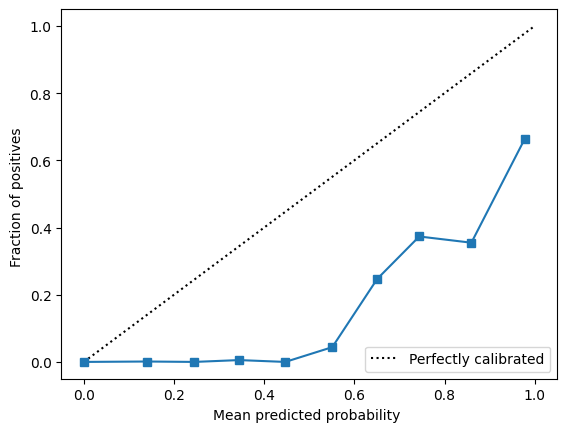

In [251]:
prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_proba)
disp.plot()

In [252]:
# ?CalibratedClassifierCV

In [264]:
from sklearn.calibration import CalibratedClassifierCV
cparams = { 'method': 'isotonic', #'isotonic', #'sigmoid',
            'ensemble':True,
            'cv': 4}

In [265]:
m = clone(MODEL).set_params(**best_params, model__random_state=2024)
calibrated = CalibratedClassifierCV(m, **cparams)

# estimator = MODEL.steps[-1][-1]
# calibrated.steps[-1] = ('model', CalibratedClassifierCV(estimator, **cparams))

In [266]:
calibrated.fit(X_resampled_10, y_resampled_10)

y_pred_c = calibrated.predict_proba(Xval)[:, 1]
y_c = calibrated.predict(Xval)

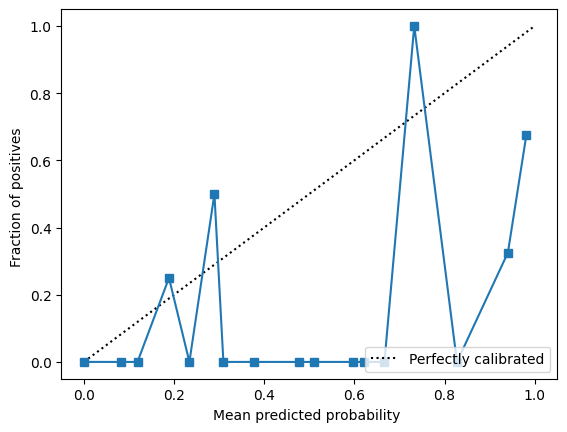

In [267]:
prob_true, prob_pred = calibration_curve(yval, y_pred_c, n_bins=20)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred_c)
disp.plot()

## Curves

In [268]:
prec, recall, step = precision_recall_curve(yval, y_pred_c, pos_label=1)

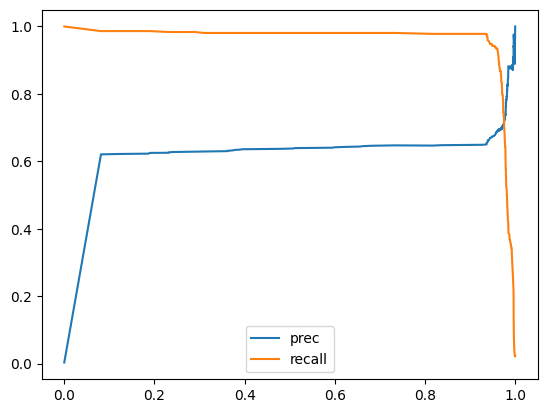

In [269]:
curve_df = pd.DataFrame({'prec':prec[:-1], 'recall':recall[:-1]}, index=step)
curve_df.plot();

In [284]:
curve_df[curve_df.index > 0.96].head(3)

,prec,recall
0.960114,0.688889,0.934247
0.960552,0.690283,0.934247
0.960648,0.689655,0.931507


In [278]:
curve_df[curve_df.index > 0.99].head(3)

,prec,recall
0.990262,0.878378,0.356164
0.990403,0.877551,0.353425
0.991700,0.874126,0.342466


## Store

In [289]:
# model_f = UnifiedModelAPI(model=calibrated,
#             columns=features,
#             modelname='lgbm_os10_calbirated',
#             v=0.3)

SE.ml.umodel.UnifiedModelAPI

In [286]:
with open('./model/model.pkl', 'wb') as f:
    pickle.dump(model_f, f)

In [291]:
! export AWS_PROFILE='sedatalakeprodreadwrite'

In [292]:
metaflow_config['run_name'] = f'binary_lbgm_data_resampled_10_hp5'
mlflow_log_model(
    calibrated,
    X_resampled_10,
    y_resampled_10,
    metaflow_config, 
    model_metadata={'sampling':'resampled_10', 'hyperopt':72},
    validation=(Xval, yval, METRICS),
    load_model=True
)

2024/03/25 17:53:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/03/25 17:53:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.
2024/03/25 17:53:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/03/25 17:53:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


S3UploadFailedError: Failed to upload /var/folders/v2/l685f8rj7jn4flt11pny4lsr0000gq/T/tmpq49em6dq/model/python_env.yaml to streeteasy-datalake/research/mlflow/793/b444d987cea941e490ed866b3cd08e73/artifacts/model/python_env.yaml: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied